# Impoet Data

In [1]:
!gdown 1tgQ6bOtnCPw6E7B0fnzJ53GLg1GtJq75

Downloading...
From (original): https://drive.google.com/uc?id=1tgQ6bOtnCPw6E7B0fnzJ53GLg1GtJq75
From (redirected): https://drive.google.com/uc?id=1tgQ6bOtnCPw6E7B0fnzJ53GLg1GtJq75&confirm=t&uuid=fac2bedf-f9e6-43b8-9c4e-50ec1beaea88
To: /content/creditcardfraud.zip
100% 69.2M/69.2M [00:02<00:00, 25.2MB/s]


In [2]:
!unzip /content/creditcardfraud.zip

Archive:  /content/creditcardfraud.zip
  inflating: creditcard.csv          


# Imports

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, accuracy_score, log_loss
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Load Data and Pre-Process

In [69]:
# Load the dataset
data = pd.read_csv('/content/creditcard.csv')

# Normalize the 'Amount' feature
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

# Drop the 'Time' feature
data = data.drop(columns=['Time'])

data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [70]:
# Split the data into features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=53)


# Over-Sampeling

In [71]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=53,sampling_strategy=1.0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
X_train_res, y_train_res = X_train, y_train

In [73]:
print("Original dataset shape:", np.bincount(y_train.astype(int)))
print("Resampled dataset shape:", np.bincount(y_train_res.astype(int)))


Original dataset shape: [199020    344]
Resampled dataset shape: [199020    344]


# Models and Training

## Denoising Auto-Encoder

In [74]:
# Define the denoising autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 22),
            nn.ReLU(),
            nn.Linear(22, 15),
            nn.ReLU(),
            nn.Linear(15, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 15),
            nn.ReLU(),
            nn.Linear(15, 22),
            nn.ReLU(),
            nn.Linear(22, 29),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the autoencoder
autoencoder = DenoisingAutoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [75]:
import numpy as np

def add_gaussian_noise(X, mean=0.0, std=1):
    noise = np.random.normal(mean, std, X.shape)
    X_noisy = X + noise
    return X_noisy

def add_salt_and_pepper_noise(X, salt_prob, pepper_prob):
    X_noisy = X.copy()
    # Adding salt noise
    num_salt = int(np.ceil(salt_prob * X.size))
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in X.shape]
    X_noisy[tuple(salt_coords)] = 1
    # Adding pepper noise
    num_pepper = int(np.ceil(pepper_prob * X.size))
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in X.shape]
    X_noisy[tuple(pepper_coords)] = 0
    return X_noisy

# Convert training and test data to numpy arrays
X_train_res_np = X_train_res.values
X_test_np = X_test.values

# Add Gaussian noise to the entire training and test sets
X_train_gaussian_noisy = add_gaussian_noise(X_train_res_np)
X_test_gaussian_noisy = add_gaussian_noise(X_test_np)

# Select 30% of the training and test sets for additional salt-and-pepper noise
num_train_samples = X_train_res_np.shape[0]
num_test_samples = X_test_np.shape[0]
train_indices = np.random.choice(num_train_samples, int(0.3 * num_train_samples), replace=False)
test_indices = np.random.choice(num_test_samples, int(0.3 * num_test_samples), replace=False)
X_train_gaussian_snp_noisy = X_train_gaussian_noisy.copy()
X_test_gaussian_snp_noisy = X_test_gaussian_noisy.copy()
X_train_gaussian_snp_noisy[train_indices] = add_salt_and_pepper_noise(X_train_gaussian_snp_noisy[train_indices], salt_prob=0.02, pepper_prob=0.02)
X_test_gaussian_snp_noisy[test_indices] = add_salt_and_pepper_noise(X_test_gaussian_snp_noisy[test_indices], salt_prob=0.02, pepper_prob=0.02)

# Convert noisy training and test data to PyTorch tensors and move to device
X_train_res_tensor = torch.tensor(X_train_res_np, dtype=torch.float32).to(device)
X_train_noisy_tensor = torch.tensor(X_train_gaussian_snp_noisy, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
X_test_noisy_tensor = torch.tensor(X_test_gaussian_snp_noisy, dtype=torch.float32).to(device)


Epoch [1/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [2/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [3/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [4/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [5/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [6/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [7/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [8/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [9/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [10/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [11/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [12/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [13/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [14/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [15/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [16/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [17/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [18/30], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [19/30], Train Loss: 0.0000, Test Loss: 0.0000
Ep

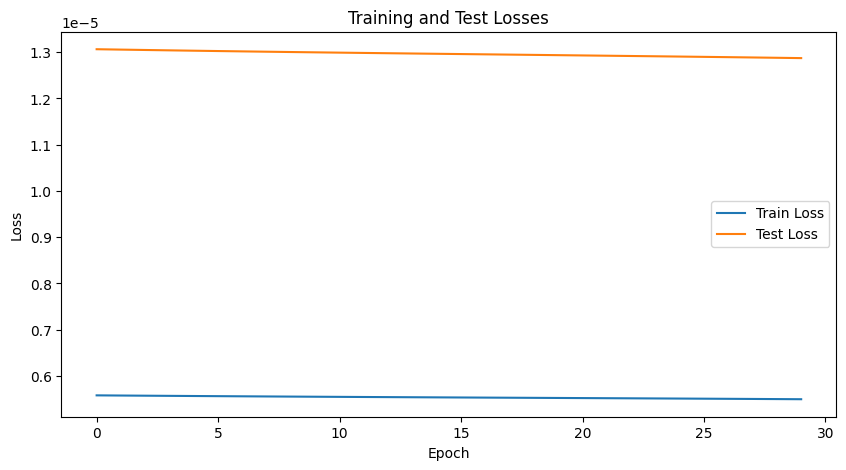

In [76]:
# Training the autoencoder and plotting losses
num_epochs = 30
batch_size = 1024**2
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    # Training
    autoencoder.train()
    for i in range(0, len(X_train_res_tensor), batch_size):
        batch = X_train_noisy_tensor[i:i+batch_size]
        target = X_train_res_tensor[i:i+batch_size]

        # Forward pass
        outputs = autoencoder(batch)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(X_train_res_tensor))

    # Evaluation on test set
    autoencoder.eval()
    with torch.no_grad():
        outputs = autoencoder(X_test_noisy_tensor)
        test_loss = criterion(outputs, X_test_tensor).item()
        test_losses.append(test_loss / len(X_test_tensor))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()


## Classifier

In [77]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(29, 22),
            nn.ReLU(),
            nn.Linear(22, 15),
            nn.ReLU(),
            nn.Linear(15, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
        )

    def forward(self, x):
        return nn.Softmax(dim=1)(self.fc(x))

# Instantiate the classifier
classifier = Classifier().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)


In [78]:
# Denoise the training and test sets using the trained autoencoder
autoencoder.eval()
with torch.no_grad():
    X_train_denoised_tensor = autoencoder(X_train_noisy_tensor)
    X_test_denoised_tensor = autoencoder(X_test_noisy_tensor)


In [79]:
import torch

num_epochs_classifier = 500
batch_size_classifier = 1024**2
train_losses_classifier = []
test_losses_classifier = []
train_recall = []
test_recall = []
train_accuracy = []
test_accuracy = []
c = 0
t = 2000
# Convert targets to PyTorch tensors and move to device
y_train_res_tensor = torch.tensor(y_train_res.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

best_test_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs_classifier):
    train_loss = 0
    test_loss = 0
    classifier.train()
    # Training
    for i in range(0, len(X_train_denoised_tensor), batch_size_classifier):
        batch_X = X_train_denoised_tensor[i:i+batch_size_classifier]
        batch_y = y_train_res_tensor[i:i+batch_size_classifier]

        # Forward pass
        outputs = classifier(batch_X)[:, 1]
        loss = criterion(outputs, batch_y.squeeze())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation on test set
    classifier.eval()
    with torch.no_grad():
        outputs_train = classifier(X_train_denoised_tensor)[:, 1]
        outputs_test = classifier(X_test_denoised_tensor)[:, 1]

        train_loss = criterion(outputs_train, y_train_res_tensor.squeeze()).item()
        test_loss = criterion(outputs_test, y_test_tensor.squeeze()).item()

        test_losses_classifier.append(test_loss)
        train_losses_classifier.append(train_loss)

        # Calculate recall and accuracy
        outputs_train = outputs_train.cpu().numpy()
        outputs_test = outputs_test.cpu().numpy()
        y_train_res_np = y_train_res_tensor.cpu().numpy()
        y_test_np = y_test_tensor.cpu().numpy()

        train_recall.append(recall_score(y_train_res_np, outputs_train.round()))
        test_recall.append(recall_score(y_test_np, outputs_test.round()))
        train_accuracy.append(accuracy_score(y_train_res_np, outputs_train.round()))
        test_accuracy.append(accuracy_score(y_test_np, outputs_test.round()))

    # Check if current test loss is the best we've seen so far
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_state = classifier.state_dict()
        c = 0
    else:
        c = c+1

    if c > t:
        break


    print(f'Epoch [{epoch+1}/{num_epochs_classifier}], Train Loss: {train_losses_classifier[-1]:.4f}, Test Loss: {test_loss:.4f}, Train Recall: {train_recall[-1]:.4f}, Test Recall: {test_recall[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.4f}, Test Accuracy: {test_accuracy[-1]:.4f}')

# Load the best model state
classifier.load_state_dict(best_model_state)
print(f'Best Test Loss: {best_test_loss:.4f}')

# Return the classifier with the best test loss
classifier


Epoch [1/500], Train Loss: 0.5517, Test Loss: 0.5517, Train Recall: 0.0000, Test Recall: 0.0000, Train Accuracy: 0.9983, Test Accuracy: 0.9983
Epoch [2/500], Train Loss: 0.5486, Test Loss: 0.5486, Train Recall: 0.0000, Test Recall: 0.0000, Train Accuracy: 0.9983, Test Accuracy: 0.9983
Epoch [3/500], Train Loss: 0.5455, Test Loss: 0.5455, Train Recall: 0.0000, Test Recall: 0.0000, Train Accuracy: 0.9983, Test Accuracy: 0.9983
Epoch [4/500], Train Loss: 0.5424, Test Loss: 0.5424, Train Recall: 0.0000, Test Recall: 0.0000, Train Accuracy: 0.9983, Test Accuracy: 0.9983
Epoch [5/500], Train Loss: 0.5393, Test Loss: 0.5393, Train Recall: 0.0000, Test Recall: 0.0000, Train Accuracy: 0.9983, Test Accuracy: 0.9983
Epoch [6/500], Train Loss: 0.5363, Test Loss: 0.5363, Train Recall: 0.0000, Test Recall: 0.0000, Train Accuracy: 0.9983, Test Accuracy: 0.9983
Epoch [7/500], Train Loss: 0.5333, Test Loss: 0.5334, Train Recall: 0.0000, Test Recall: 0.0000, Train Accuracy: 0.9983, Test Accuracy: 0.9983

Classifier(
  (fc): Sequential(
    (0): Linear(in_features=29, out_features=22, bias=True)
    (1): ReLU()
    (2): Linear(in_features=22, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): ReLU()
    (8): Linear(in_features=5, out_features=2, bias=True)
  )
)

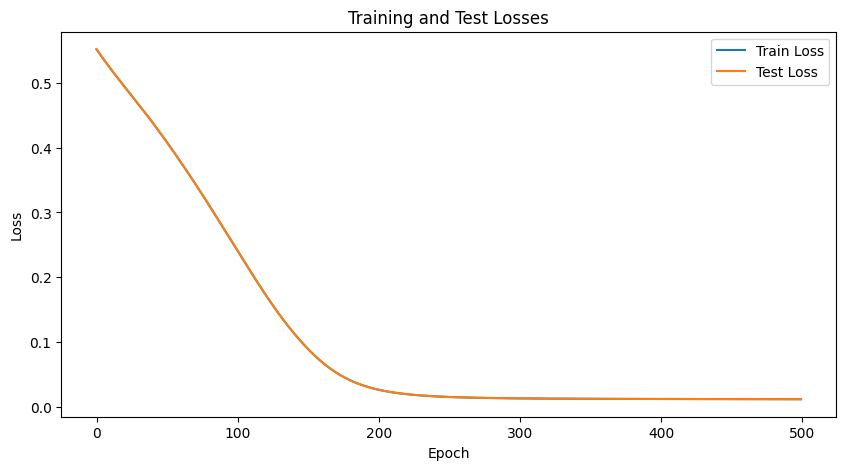

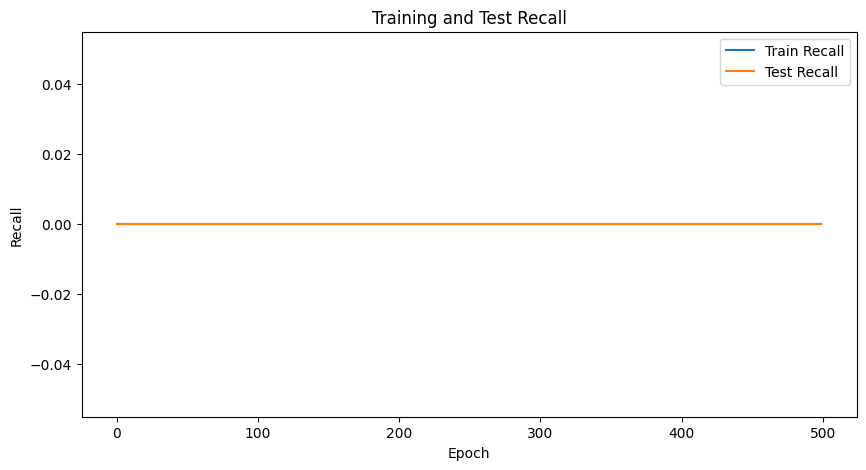

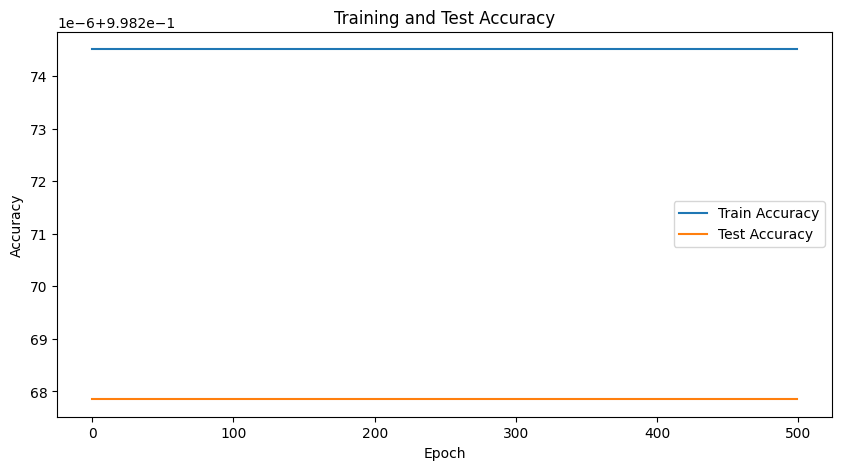

In [80]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses_classifier, label='Train Loss')
plt.plot(test_losses_classifier, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

# Plotting the recall
plt.figure(figsize=(10, 5))
plt.plot(train_recall, label='Train Recall')
plt.plot(test_recall, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Test Recall')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()


# Evaluation

In [81]:
# Prepare test data and move to device
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Denoise the test data
with torch.no_grad():
    X_test_denoised = autoencoder(X_test_tensor)

# Predict
with torch.no_grad():
    outputs = classifier(X_test_denoised)
    _, predicted = torch.max(outputs.data, 1)

# Move predictions back to CPU for evaluation
predicted = predicted.cpu()
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Evaluate the model
recall = recall_score(y_test_tensor, predicted)
print(f'Recall: {recall:.4f}')


Recall: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



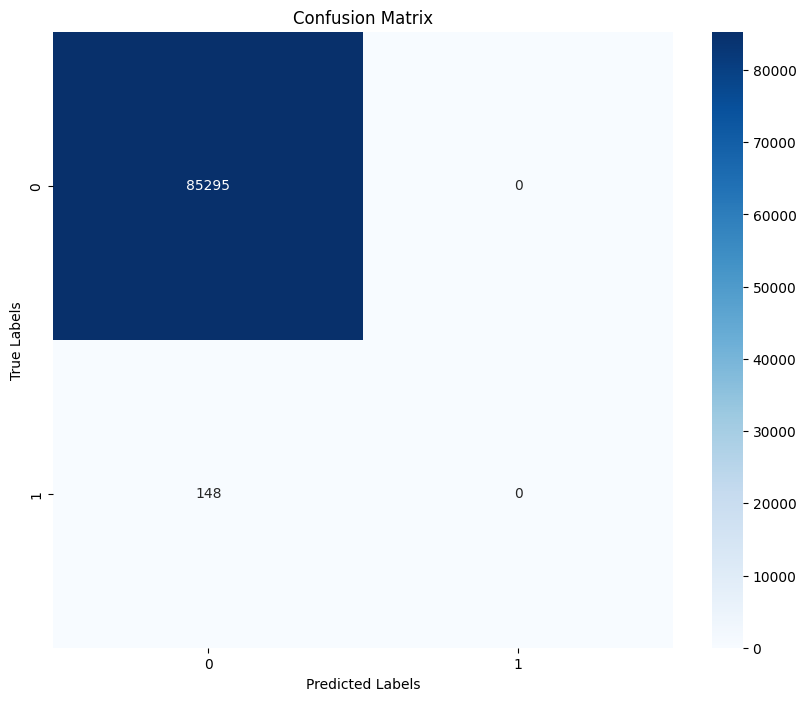

In [85]:

# Assuming you have your model, criterion, and test_loader ready
# model = ...
# criterion = ...
# test_loader = ...

# Set the model to evaluation mode
classifier.eval()

# Lists to store true labels and predictions
true_labels = []
predictions = []

# Disable gradient calculation
with torch.no_grad():
    # Move inputs and labels to the device (GPU or CPU)
    inputs, labels = X_test_denoised_tensor.to(device), y_test_tensor.to(device)

    # Get model predictions
    outputs = classifier(inputs)
    _, preds = torch.max(outputs, 1)

    # Append to lists
    true_labels.extend(labels.cpu().numpy())
    predictions.extend(preds.cpu().numpy())

# Calculate classification report
class_report = classification_report(true_labels, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print classification report
print("Classification Report:\n", class_report)


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, accuracy_score

def calculate_metrics(outputs, labels, thresholds):
    recalls = []
    accuracies = []

    for threshold in thresholds:
        predictions = (outputs > threshold).astype(int)
        recall = recall_score(labels, predictions)
        accuracy = accuracy_score(labels, predictions)
        recalls.append(recall)
        accuracies.append(accuracy)

    return recalls, accuracies






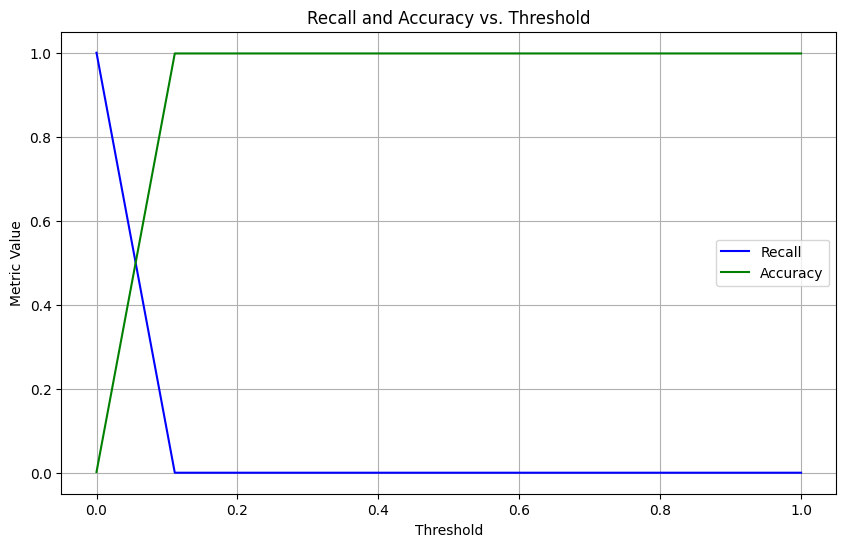

In [84]:
with torch.no_grad():
    # Move inputs and labels to the device (GPU or CPU)
    inputs = X_test_denoised_tensor.to(device)

    # Get model predictions
    preds = classifier(inputs)[:,1]


# Convert outputs and labels to numpy arrays
outputs_test_np = preds.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Define the thresholds
thresholds = np.linspace(0, 1, 10)

# Calculate the metrics
test_recalls, test_accuracies = calculate_metrics(outputs_test_np, y_test_np, thresholds)

# Plotting the recall and accuracy for different thresholds on the same figure
plt.figure(figsize=(10, 6))

# Plot Recall
plt.plot(thresholds, test_recalls, label='Recall', color='blue')

# Plot Accuracy
plt.plot(thresholds, test_accuracies, label='Accuracy', color='green')

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Recall and Accuracy vs. Threshold')
plt.legend()
plt.grid(True)

plt.show()
